### Download model

https://github.com/mapbox/robosat/releases 
Find last release and download (I used 1.2.0)

In [13]:
import torch
import torch.onnx
import torch.nn as nn

import torchvision
from torchvision.models import resnet50
from torchvision.transforms import Compose, Normalize

import matplotlib.pyplot as plt
import onnxruntime as rt
from PIL import Image
import numpy as np
import onnx
import cv2
import os

### Load Pytorch model

In [2]:
"""U-Net inspired encoder-decoder architecture with a ResNet encoder as proposed by Alexander Buslaev.

See:
- https://arxiv.org/abs/1505.04597 - U-Net: Convolutional Networks for Biomedical Image Segmentation
- https://arxiv.org/abs/1411.4038  - Fully Convolutional Networks for Semantic Segmentation
- https://arxiv.org/abs/1512.03385 - Deep Residual Learning for Image Recognition
- https://arxiv.org/abs/1801.05746 - TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation
- https://arxiv.org/abs/1806.00844 - TernausNetV2: Fully Convolutional Network for Instance Segmentation

"""

class ConvRelu(nn.Module):
    def __init__(self, num_in, num_out):
        super().__init__()
        self.block = nn.Conv2d(num_in, num_out, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        return nn.functional.relu(self.block(x), inplace=True)

class DecoderBlock(nn.Module):

    def __init__(self, num_in, num_out):
        super().__init__()
        self.block = ConvRelu(num_in, num_out)

    def forward(self, x):
        return self.block(nn.functional.interpolate(x, scale_factor=2, mode="nearest"))

class UNet(nn.Module):
    def __init__(self, num_classes, num_filters=32, pretrained=True):
        super().__init__()

        self.resnet = resnet50(pretrained=pretrained)
        self.center = DecoderBlock(2048, num_filters * 8)

        self.dec0 = DecoderBlock(2048 + num_filters * 8, num_filters * 8)
        self.dec1 = DecoderBlock(1024 + num_filters * 8, num_filters * 8)
        self.dec2 = DecoderBlock(512 + num_filters * 8, num_filters * 2)
        self.dec3 = DecoderBlock(256 + num_filters * 2, num_filters * 2 * 2)
        self.dec4 = DecoderBlock(num_filters * 2 * 2, num_filters)
        self.dec5 = ConvRelu(num_filters, num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        size = x.size()
        assert size[-1] % 32 == 0 and size[-2] % 32 == 0, "image resolution has to be divisible by 32 for resnet"

        enc0 = self.resnet.conv1(x)
        enc0 = self.resnet.bn1(enc0)
        enc0 = self.resnet.relu(enc0)
        enc0 = self.resnet.maxpool(enc0)

        enc1 = self.resnet.layer1(enc0)
        enc2 = self.resnet.layer2(enc1)
        enc3 = self.resnet.layer3(enc2)
        enc4 = self.resnet.layer4(enc3)

        center = self.center(nn.functional.max_pool2d(enc4, kernel_size=2, stride=2))

        dec0 = self.dec0(torch.cat([enc4, center], dim=1))
        dec1 = self.dec1(torch.cat([enc3, dec0], dim=1))
        dec2 = self.dec2(torch.cat([enc2, dec1], dim=1))
        dec3 = self.dec3(torch.cat([enc1, dec2], dim=1))
        dec4 = self.dec4(dec3)
        dec5 = self.dec5(dec4)

        return self.final(dec5)


state = torch.load("robosat/bavaria-dop80-checkpoint.pth", map_location='cpu')

# replace state_keys to match keys in the model
state_dict = state["state_dict"]
for key in list(state_dict.keys()):
    state_dict[key.replace('module.', '')] = state_dict.pop(key)
state["state_dict"] = state_dict

model = UNet(2)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [3]:
# switch to inference mode
model.eval();

### Convert

In [4]:
onnx_model_path = "bavaria-dop80-checkpoint.onnx"
IM_SZ = 512

# Create the right input shape
sample_batch_size = 1
channel = 3
height = IM_SZ
width = IM_SZ
dummy_input = torch.randn(sample_batch_size, channel, height, width)

# no need for grad during inference
with torch.no_grad():
    torch.onnx.export(model, dummy_input, onnx_model_path, opset_version=11)

# Check ONNX model
onnx_model = onnx.load(onnx_model_path)

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)

c:\python\python36\lib\site-packages\ipykernel_launcher.py:57: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


## Compare outputs of Pytorch vs Onnx

### Prepare Input data

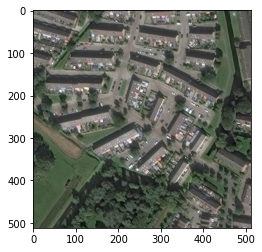

(1, 3, 512, 512)
[0.33093587 0.22818734 0.22818734 0.26243685 0.34806062 0.34806062
 0.17681308 0.14256358 0.26243685 0.26243685]


In [36]:
test_dir_path = "H:\Projects\SpaceNet2\Images"
image_path = os.path.join(test_dir_path, "SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823091132_20190823091448_tile_7924.tif")
image = Image.open(image_path)
image = np.array(image)
image = image[:512, :512, :]

# show picture
plt.imshow(image)
plt.show()

# Pytorch ToTensor()
image = image.transpose((2, 0, 1))
image = image / 255  

# Pytorch Normalize()
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
for channel in range(image.shape[0]):
    image[channel,:,:] = (image[channel,:,:] - mean[channel]) / std[channel] 

image = np.array([image])
print(image.shape)
print(image[0, 0, :10, 0])

### Run Onnx model

In [37]:
sess = rt.InferenceSession(onnx_model_path)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
print(input_name)
print(label_name)

pred = sess.run([label_name], {input_name: image.astype(np.float32)})[0]

input.1
551


In [38]:
output = pred.squeeze(0)
mask = output.argmax(axis=0).astype(np.uint8)
print("mask shape: ", mask.shape)

mask shape:  (512, 512)


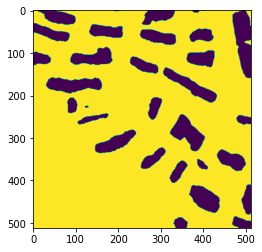

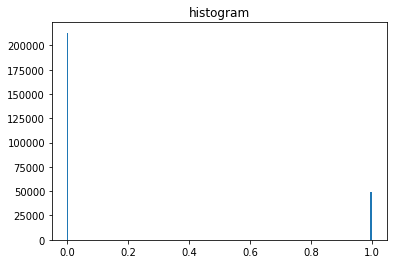

In [39]:
m = mask < 0.5
plt.imshow(m)
plt.show()

plt.hist(mask.flatten(), bins = 255)
plt.title("histogram") 
plt.show()

### Run Pytorch model

In [41]:
with torch.no_grad():
    image_tensor = torch.Tensor(image)
    output_pytorch = model(image_tensor)
    output_pytorch = output_pytorch.cpu().data.numpy()
    output_pytorch = output_pytorch.squeeze(0)

    mask_pytorch = output_pytorch.argmax(axis=0).astype(np.uint8)

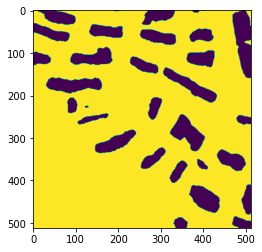

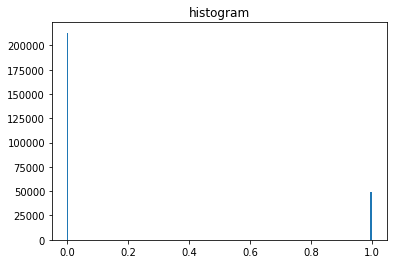

In [42]:
m_pytorch = mask_pytorch < 0.5
plt.imshow(m_pytorch)
plt.show()

plt.hist(mask_pytorch.flatten(), bins = 255)
plt.title("histogram") 
plt.show()

### Compare

In [52]:
# compare 2 outputs to 4 decimal places
np.testing.assert_array_almost_equal(output, output_pytorch, decimal=4)